# Testing

This is a notebook to test C3A v different CCA methods.

## Imports

In [1]:
import numpy as np
from sklearn.cross_decomposition import CCA
from c3a import C3A
from gemmr.generative_model import GEMMR
from gemmr.estimators import SVDCCA
import matplotlib.pyplot as plt
import scipy.stats 


## Generate data

This generates two matricies with a known canoncial correaltion of around 0.3

In [21]:
model_definition = GEMMR('cca', wx=50, wy=50, r_between=0.3)
behavioural_data_study1, imging_data_study1 = model_definition.generate_data(n=20000)
behavioural_data_study2, imging_data_study2 = model_definition.generate_data(n=1900)
study1 = (imging_data_study1, behavioural_data_study1) 
study2 = (imging_data_study2, behavioural_data_study2)

## Fit models

In [22]:
cca = CCA(n_components=1)
gmmr_cca = SVDCCA(calc_loadings=True)
c3a_model = C3A(l2=0)
X_sck, Y_sck = cca.fit_transform(behavioural_data_study1, imging_data_study1)
X_gmmr, Y_gmmr = gmmr_cca.fit_transform(behavioural_data_study1, imging_data_study1)
projections = c3a_model.fit_transform(study1)
x_c3a = projections[0][0]
y_c3a = projections[0][1]

In [35]:
gmmr_cca.x_loadings_

array([[-0.63112656],
       [-0.12205433],
       [-0.19556509],
       [-0.44611047],
       [-0.28162252],
       [ 0.10948567],
       [-0.08548132],
       [ 0.03131443],
       [ 0.00915081],
       [-0.02658573],
       [-0.06964683],
       [-0.12554316],
       [-0.10165184],
       [-0.0029553 ],
       [-0.06997275],
       [-0.03106116],
       [-0.13229696],
       [-0.02390196],
       [-0.0493635 ],
       [ 0.07388032],
       [ 0.23089402],
       [-0.08005531],
       [-0.02832945],
       [ 0.08675619],
       [-0.12519205],
       [ 0.11111083],
       [ 0.00689673],
       [-0.01613354],
       [-0.10804276],
       [-0.08842893],
       [ 0.01694639],
       [-0.02394734],
       [ 0.04860156],
       [ 0.12439829],
       [ 0.05768533],
       [-0.05882354],
       [-0.01803281],
       [-0.02596421],
       [ 0.02342019],
       [-0.00403051],
       [ 0.06318289],
       [ 0.05629448],
       [ 0.11673036],
       [-0.07688574],
       [ 0.0113051 ],
       [ 0

In [ ]:
cca1 = loadings1
cca2 = gmmr_cca.x_loadings_
cca3 = c3a_model.compute_loadings(study1)[0][0]
x = np.arange(len(cca1))
plt.figure(figsize=(12, 6))
plt.plot(x, cca1, label="CCA1")
plt.plot(x, cca2, label="CCA2")
plt.plot(x, cca3, label="C3A (yours)")
plt.axhline(0, color='grey', linestyle='--')
plt.xlabel("Feature Index")
plt.ylabel("Loading Value")
plt.title("Canonical Loadings Comparison")
plt.legend()
plt.tight_layout()
plt.show()

## Correlations

In [23]:
gmmr_cor = float(gmmr_cca.corrs_[0])
sklearn_corr = np.corrcoef(X_sck.T, Y_sck.T)[0, 1]
ca3_corr = c3a_model.calculate_canonical_correlations()[0]
print(f"Sckit learn: {sklearn_corr:.3f}")
print(f"GEMMR: {gmmr_cor:.3f}")
print(f"C3A: {ca3_corr:.3f}")

Sckit learn: 0.316
GEMMR: 0.316
C3A: 0.315


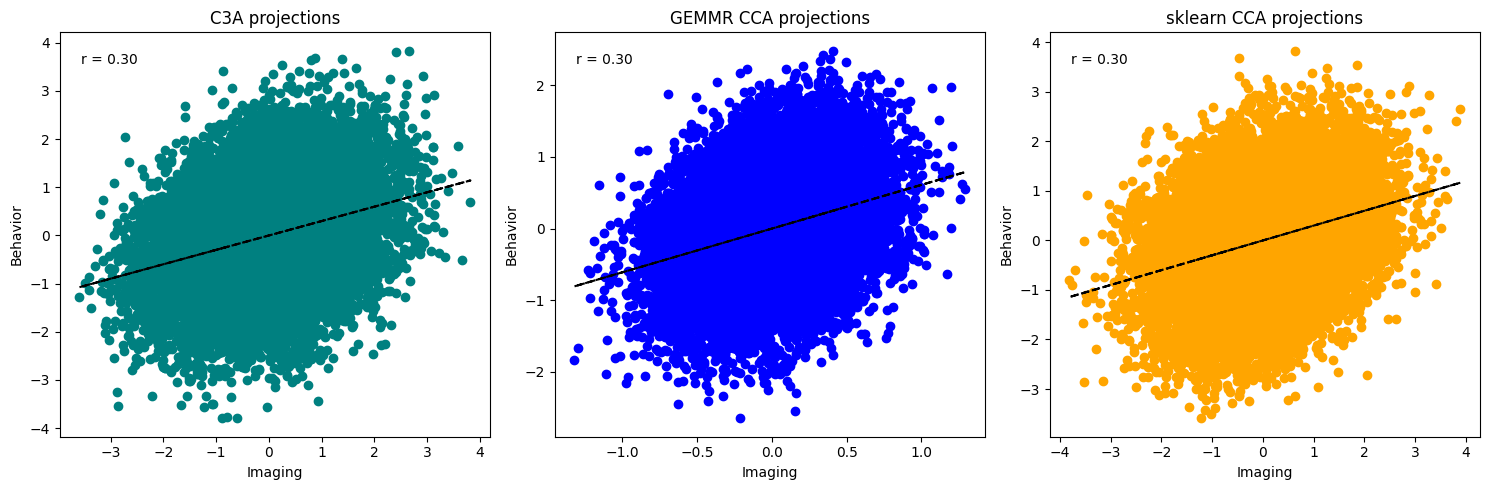

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(x_c3a, y_c3a, c='teal')
m, b = np.polyfit(x_c3a.flatten(), y_c3a.flatten(), 1)
plt.plot(x_c3a, m*x_c3a + b, color='black', linestyle='--')
plt.text(0.05, 0.95, f"r = {ca3_corr:.2f}", 
         transform=plt.gca().transAxes, va='top', ha='left')
plt.title("C3A projections")
plt.xlabel("Imaging")
plt.ylabel("Behavior")

plt.subplot(1, 3, 2)
plt.scatter(X_gmmr, Y_gmmr, c='blue', label=f"r = {gmmr_cor:.2f}")
m, b = np.polyfit(X_gmmr.flatten(), Y_gmmr.flatten(), 1)
plt.plot(X_gmmr, m*X_gmmr + b, color='black', linestyle='--')
plt.text(0.05, 0.95, f"r = {gmmr_cor:.2f}", 
         transform=plt.gca().transAxes, va='top', ha='left')
plt.title("GEMMR CCA projections")
plt.xlabel("Imaging")
plt.ylabel("Behavior")

plt.subplot(1, 3, 3)
plt.scatter(X_sck, Y_sck, c='orange', label=f"r = {sklearn_corr:.2f}")
m, b = np.polyfit(X_sck.flatten(), Y_sck.flatten(), 1)
plt.plot(X_sck, m*X_sck + b, color='black', linestyle='--')
plt.text(0.05, 0.95, f"r = {sklearn_corr:.2f}", 
         transform=plt.gca().transAxes, va='top', ha='left')
plt.title("sklearn CCA projections")
plt.xlabel("Imaging")
plt.ylabel("Behavior")

plt.tight_layout()
plt.show()

In [6]:
display(scipy.stats.ttest_ind(x_c3a.flatten(), X_gmmr.flatten() ))
display(scipy.stats.ttest_ind(y_c3a.flatten(), Y_gmmr.flatten() ))


TtestResult(statistic=np.float64(2.816624037041549e-17), pvalue=np.float64(1.0), df=np.float64(3998.0))

TtestResult(statistic=np.float64(-1.684091284011002e-16), pvalue=np.float64(0.9999999999999999), df=np.float64(3998.0))